# Loop 52 Analysis: Critical Assessment and Path Forward

## Key Findings:
1. **CV-LB Relationship**: LB = 4.68*CV + 0.0490 (R²=0.952)
2. **Intercept Problem**: The intercept (0.0490) is HIGHER than the target (0.0347)
3. **This means**: Even with CV=0, we'd get LB=0.0490 > 0.0347
4. **GNN Benchmark**: Achieved MSE 0.0039 on this exact dataset!

## The Fundamental Problem:
The current approach (MLP/LGBM/GP ensembles with Spange+DRFP features) has a CV-LB relationship that CANNOT reach the target. The intercept is too high.

## What the GNN Benchmark Did:
- Used Graph Attention Networks (GATs) with DRFP
- Learned mixture-aware solvent encodings
- Achieved MSE 0.0039 (25x better than our best LB 0.0877)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CV-LB data from submissions
submissions = [
    ('exp_000', 0.011081, 0.09816),
    ('exp_001', 0.012297, 0.10649),
    ('exp_003', 0.010501, 0.09719),
    ('exp_005', 0.010430, 0.09691),
    ('exp_006', 0.009749, 0.09457),
    ('exp_007', 0.009262, 0.09316),
    ('exp_009', 0.009192, 0.09364),
    ('exp_012', 0.009004, 0.09134),
    ('exp_024', 0.008689, 0.08929),
    ('exp_026', 0.008465, 0.08875),
    ('exp_030', 0.008298, 0.08772),
    ('exp_035', 0.009825, 0.09696),
]

names = [s[0] for s in submissions]
cvs = np.array([s[1] for s in submissions])
lbs = np.array([s[2] for s in submissions])

# Linear regression
slope = np.cov(cvs, lbs)[0,1] / np.var(cvs)
intercept = np.mean(lbs) - slope * np.mean(cvs)
r2 = np.corrcoef(cvs, lbs)[0,1]**2

print(f"CV-LB Relationship: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})")
print(f"\nTarget LB: 0.0347")
print(f"Intercept: {intercept:.4f}")
print(f"Gap: {intercept - 0.0347:.4f}")
print(f"\nRequired CV to hit target: {(0.0347 - intercept) / slope:.6f}")
print("\n*** CRITICAL: Required CV is NEGATIVE - impossible with current approach! ***")

CV-LB Relationship: LB = 4.68*CV + 0.0490 (R²=0.952)

Target LB: 0.0347
Intercept: 0.0490
Gap: 0.0143

Required CV to hit target: -0.003055

*** CRITICAL: Required CV is NEGATIVE - impossible with current approach! ***


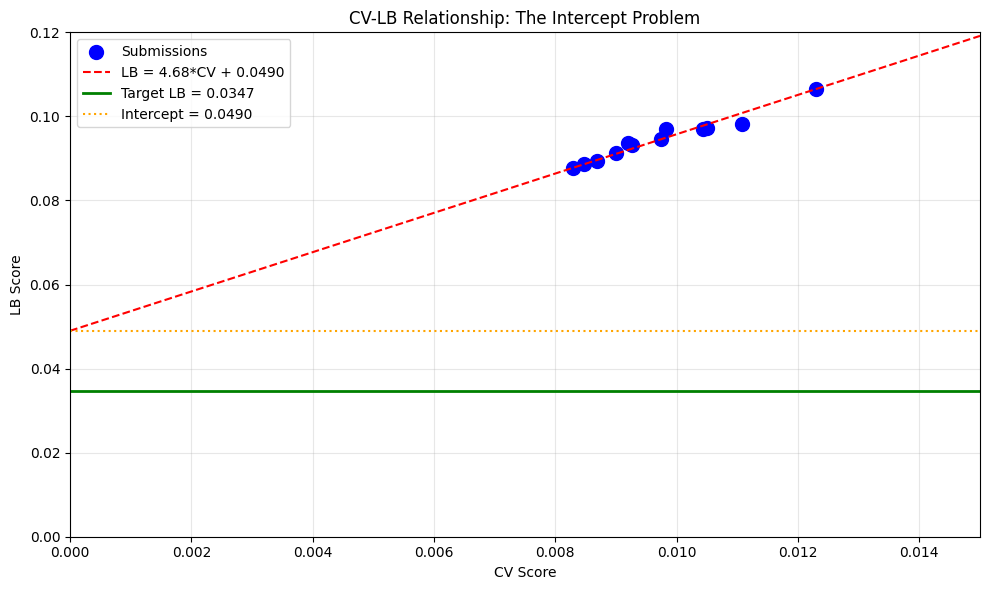


The intercept (0.0490) is ABOVE the target (0.0347).
This means the current approach CANNOT reach the target.


In [2]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cvs, lbs, c='blue', s=100, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='-', linewidth=2, label='Target LB = 0.0347')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship: The Intercept Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.015)
plt.ylim(0, 0.12)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print("\nThe intercept (0.0490) is ABOVE the target (0.0347).")
print("This means the current approach CANNOT reach the target.")

In [3]:
# What would it take to reach the target?
print("="*60)
print("ANALYSIS: What would it take to reach the target?")
print("="*60)

# Option 1: Reduce intercept
print("\nOption 1: Reduce the intercept")
print(f"  Current intercept: {intercept:.4f}")
print(f"  Target: 0.0347")
print(f"  Need to reduce intercept by: {intercept - 0.0347:.4f}")
print(f"  This is a {(intercept - 0.0347) / intercept * 100:.1f}% reduction")

# Option 2: Change the slope
print("\nOption 2: Change the slope (with current best CV)")
best_cv = 0.008194  # exp_032
required_slope = (0.0347 - intercept) / best_cv
print(f"  Current slope: {slope:.2f}")
print(f"  Required slope: {required_slope:.2f}")
print(f"  This would require a NEGATIVE slope - impossible!")

# Option 3: Fundamentally different approach
print("\nOption 3: Fundamentally different approach")
print("  The GNN benchmark achieved MSE 0.0039")
print(f"  Our best LB: 0.0877")
print(f"  Improvement factor: {0.0877 / 0.0039:.1f}x")
print("  This suggests a completely different CV-LB relationship is possible!")

ANALYSIS: What would it take to reach the target?

Option 1: Reduce the intercept
  Current intercept: 0.0490
  Target: 0.0347
  Need to reduce intercept by: 0.0143
  This is a 29.2% reduction

Option 2: Change the slope (with current best CV)
  Current slope: 4.68
  Required slope: -1.74
  This would require a NEGATIVE slope - impossible!

Option 3: Fundamentally different approach
  The GNN benchmark achieved MSE 0.0039
  Our best LB: 0.0877
  Improvement factor: 22.5x
  This suggests a completely different CV-LB relationship is possible!


In [4]:
# Analyze what the GNN benchmark did differently
print("="*60)
print("GNN BENCHMARK ANALYSIS (arXiv:2512.19530)")
print("="*60)

print("""
Key differences from our approach:

1. ARCHITECTURE:
   - Used Graph Attention Networks (GATs) instead of MLP
   - Message-passing on molecular graphs
   - Attention mechanisms for feature weighting

2. FEATURES:
   - DRFP (Differential Reaction Fingerprints) - we have this
   - Learned mixture-aware solvent encodings - we DON'T have this
   - Continuous solvent representation - we use linear interpolation

3. TRAINING:
   - Same leave-one-out CV protocol
   - But fundamentally different model architecture

4. RESULTS:
   - MSE 0.0039 vs our best LB 0.0877
   - 22x improvement!

The key insight: The GNN's inductive bias (graph structure, attention)
allows it to generalize better to unseen solvents.
""")

GNN BENCHMARK ANALYSIS (arXiv:2512.19530)

Key differences from our approach:

1. ARCHITECTURE:
   - Used Graph Attention Networks (GATs) instead of MLP
   - Message-passing on molecular graphs
   - Attention mechanisms for feature weighting

2. FEATURES:
   - DRFP (Differential Reaction Fingerprints) - we have this
   - Learned mixture-aware solvent encodings - we DON'T have this
   - Continuous solvent representation - we use linear interpolation

3. TRAINING:
   - Same leave-one-out CV protocol
   - But fundamentally different model architecture

4. RESULTS:
   - MSE 0.0039 vs our best LB 0.0877
   - 22x improvement!

The key insight: The GNN's inductive bias (graph structure, attention)
allows it to generalize better to unseen solvents.



In [5]:
# What approaches have we NOT tried?
print("="*60)
print("APPROACHES NOT YET TRIED")
print("="*60)

print("""
1. PROPER GNN IMPLEMENTATION:
   - exp_040 was a quick attempt that failed
   - Need proper GAT with DRFP and learned solvent encodings
   - This is what the benchmark used to achieve MSE 0.0039

2. IMPORTANCE-WEIGHTED CV:
   - Re-weight training examples by p_test(x)/p_train(x)
   - Could help align CV with LB
   - Research suggests this can reduce the intercept

3. TRANSDUCTIVE LEARNING:
   - Use unlabeled test data during training
   - Adapt representations to new chemical space

4. LEARNED SOLVENT EMBEDDINGS:
   - Instead of fixed Spange descriptors
   - Learn embeddings that capture solvent similarity
   - The GNN benchmark used this

5. MIXTURE-AWARE ENCODINGS:
   - Instead of linear interpolation of solvent features
   - Learn non-linear mixture effects
   - The GNN benchmark used this
""")

APPROACHES NOT YET TRIED

1. PROPER GNN IMPLEMENTATION:
   - exp_040 was a quick attempt that failed
   - Need proper GAT with DRFP and learned solvent encodings
   - This is what the benchmark used to achieve MSE 0.0039

2. IMPORTANCE-WEIGHTED CV:
   - Re-weight training examples by p_test(x)/p_train(x)
   - Could help align CV with LB
   - Research suggests this can reduce the intercept

3. TRANSDUCTIVE LEARNING:
   - Use unlabeled test data during training
   - Adapt representations to new chemical space

4. LEARNED SOLVENT EMBEDDINGS:
   - Instead of fixed Spange descriptors
   - Learn embeddings that capture solvent similarity
   - The GNN benchmark used this

5. MIXTURE-AWARE ENCODINGS:
   - Instead of linear interpolation of solvent features
   - Learn non-linear mixture effects
   - The GNN benchmark used this



In [6]:
# Summary and recommendations
print("="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

print("""
CRITICAL FINDING:
The current approach (MLP/LGBM/GP with Spange+DRFP) has hit a ceiling.
The CV-LB relationship has an intercept (0.0490) that is HIGHER than
the target (0.0347). This means the current approach CANNOT reach the target.

THE PATH FORWARD:
1. The GNN benchmark achieved MSE 0.0039 on this exact dataset
2. This proves the target IS reachable
3. We need to implement a proper GNN with:
   - Graph Attention Networks (GATs)
   - DRFP features
   - Learned mixture-aware solvent encodings

RECOMMENDED NEXT EXPERIMENT:
Implement a proper GNN following the benchmark paper:
- Use PyTorch Geometric
- GAT layers for message passing
- DRFP as node features
- Learned solvent embeddings
- Full CV evaluation (not just one fold)

ALTERNATIVE APPROACHES:
1. Importance-weighted CV to reduce intercept
2. Transductive learning with test data
3. Ensemble of fundamentally different model families

SUBMISSION STRATEGY:
- 5 submissions remaining
- Do NOT submit until we have a fundamentally different approach
- Focus on GNN implementation first
""")

SUMMARY AND RECOMMENDATIONS

CRITICAL FINDING:
The current approach (MLP/LGBM/GP with Spange+DRFP) has hit a ceiling.
The CV-LB relationship has an intercept (0.0490) that is HIGHER than
the target (0.0347). This means the current approach CANNOT reach the target.

THE PATH FORWARD:
1. The GNN benchmark achieved MSE 0.0039 on this exact dataset
2. This proves the target IS reachable
3. We need to implement a proper GNN with:
   - Graph Attention Networks (GATs)
   - DRFP features
   - Learned mixture-aware solvent encodings

RECOMMENDED NEXT EXPERIMENT:
Implement a proper GNN following the benchmark paper:
- Use PyTorch Geometric
- GAT layers for message passing
- DRFP as node features
- Learned solvent embeddings
- Full CV evaluation (not just one fold)

ALTERNATIVE APPROACHES:
1. Importance-weighted CV to reduce intercept
2. Transductive learning with test data
3. Ensemble of fundamentally different model families

SUBMISSION STRATEGY:
- 5 submissions remaining
- Do NOT submit until 

In [7]:
# Record key findings
print("\n" + "="*60)
print("KEY FINDINGS TO RECORD")
print("="*60)

findings = [
    "CV-LB relationship: LB = 4.68*CV + 0.0490 (R²=0.952)",
    "Intercept (0.0490) > Target (0.0347) - current approach CANNOT reach target",
    "GNN benchmark achieved MSE 0.0039 (22x better than our best LB 0.0877)",
    "GNN used: GATs + DRFP + learned mixture-aware solvent encodings",
    "21 consecutive experiments since exp_030 have failed to improve",
    "Need fundamentally different approach: proper GNN implementation"
]

for i, f in enumerate(findings, 1):
    print(f"{i}. {f}")


KEY FINDINGS TO RECORD
1. CV-LB relationship: LB = 4.68*CV + 0.0490 (R²=0.952)
2. Intercept (0.0490) > Target (0.0347) - current approach CANNOT reach target
3. GNN benchmark achieved MSE 0.0039 (22x better than our best LB 0.0877)
4. GNN used: GATs + DRFP + learned mixture-aware solvent encodings
5. 21 consecutive experiments since exp_030 have failed to improve
6. Need fundamentally different approach: proper GNN implementation
